<a href="https://colab.research.google.com/github/rioasakawey/chronos-sae-training/blob/main/stock_data_chronos_sae_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train SAE on Chronos Time Series Model

This notebook trains a Sparse Autoencoder (SAE) on Amazon's Chronos time series forecasting model.

**Architecture**: BatchTopK SAE on Chronos-T5-Small encoder activations

**Key specs**:
- Model: `amazon/chronos-t5-small` (512 hidden dim, 6 encoder layers)
- SAE: 4096 features (8x expansion), k=32 sparsity
- Data: Synthetic time series (no downloads required)

## Cell 1: Setup & Installation

In [ ]:
!pip install -q chronos-forecasting torch tqdm matplotlib numpy

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.7/72.7 kB 7.7 MB/s eta 0:00:00
PyTorch version: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4
VRAM: 15.8 GB


## Cell 2: Configuration

In [ ]:
from dataclasses import dataclass

@dataclass
class Config:
    # Model
    chronos_model: str = "amazon/chronos-t5-small"
    layer_idx: int = 4  # Mid-late layer (0-5 available)

    # SAE
    d_model: int = 512      # Chronos-small hidden dim
    d_sae: int = 4096       # 8x expansion
    k: int = 32             # Top-k sparsity

    # Training
    batch_size: int = 32    # Number of time series per batch
    activation_batch_size: int = 2048  # Number of activation vectors per SAE update
    learning_rate: float = 1e-4
    total_steps: int = 10000
    warmup_steps: int = 500
    grad_clip: float = 1.0

    # Data
    context_length: int = 512

    # Logging
    log_every: int = 100
    checkpoint_every: int = 2000

    # Device
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    dtype: str = "bfloat16" if torch.cuda.is_available() else "float32"

config = Config()
print(f"Training on: {config.device}")
print(f"SAE: {config.d_model} -> {config.d_sae} (k={config.k})")

Training on: cuda
SAE: 512 -> 4096 (k=32)


## Cell 3: Chronos Activation Extractor

In [ ]:
from chronos import ChronosPipeline
import torch.nn as nn
from typing import Optional

class ChronosActivationExtractor:
    """Extracts activations from a specific layer of Chronos T5 encoder."""

    def __init__(self, model_name: str, layer_idx: int, device: str, dtype: str):
        self.device = device
        self.dtype = dtype
        self.layer_idx = layer_idx

        # Load Chronos pipeline
        print(f"Loading {model_name}...")
        self.pipeline = ChronosPipeline.from_pretrained(
            model_name,
            device_map=device,
            dtype=dtype,
        )

        # Access the T5 encoder
        self.encoder = self.pipeline.model.model.encoder

        # Storage for captured activations
        self.activations: Optional[torch.Tensor] = None

        # Register hook on target layer
        self._register_hook()

        print(f"Extractor ready. Capturing layer {layer_idx} activations.")

    def _register_hook(self):
        """Register forward hook on the target encoder block."""
        target_block = self.encoder.block[self.layer_idx]

        def hook_fn(module, input, output):
            # T5 block output is a tuple, first element is hidden states
            hidden_states = output[0]
            self.activations = hidden_states.detach()

        self.hook = target_block.register_forward_hook(hook_fn)

    @torch.no_grad()
    def extract(self, time_series: torch.Tensor) -> torch.Tensor:
        """
        Extract activations for a batch of time series.

        Args:
            time_series: (batch, seq_len) tensor of time series values

        Returns:
            activations: (batch, token_seq_len, d_model) tensor
        """
        # embed() expects CPU input
        time_series_cpu = time_series.cpu()

        # Get embeddings (returns on CPU)
        embeddings, scale = self.pipeline.embed(time_series_cpu)

        # Move embeddings to model device
        embeddings = embeddings.to(self.device)

        # Create attention mask on same device
        attention_mask = torch.ones(
            embeddings.shape[:2],
            device=self.device,
            dtype=torch.long
        )

        # Forward through encoder to trigger hook
        self.encoder(
            inputs_embeds=embeddings,
            attention_mask=attention_mask,
        )

        # Return captured activations (convert to float32 for SAE training)
        return self.activations.float()

    def remove_hook(self):
        """Remove the forward hook."""
        self.hook.remove()

# Test the extractor
extractor = ChronosActivationExtractor(
    config.chronos_model,
    config.layer_idx,
    config.device,
    config.dtype
)

# Quick test
test_ts = torch.randn(2, config.context_length)
test_acts = extractor.extract(test_ts)
print(f"Test activation shape: {test_acts.shape}")
print(f"Expected: (2, seq_len, {config.d_model})")

Loading amazon/chronos-t5-small...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

Extractor ready. Capturing layer 4 activations.
Test activation shape: torch.Size([2, 513, 512])
Expected: (2, seq_len, 512)


## Cell 4: Synthetic Data Generator

Downloading:  70%|███████   | 119/170 [00:28<00:21,  2.40it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PXD']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  72%|███████▏  | 122/170 [00:29<00:17,  2.70it/s]ERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: HES"}}}
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HES']: YFTzMissingError('possibly delisted; no timezone found')
Downloading:  93%|█████████▎| 158/170 [00:37<00:01,  6.46it/s]ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ATVI']: YFTzMissingError('possibly delisted; no timezone found')
Downloading: 100%|██████████| 170/170 [00:40<00:00,  4.19it/s]



Download complete:
  Successful: 167 stocks
  Failed: 3 stocks
  Total windows: 2,661
  Data ready for training!

Sample stock windows:
Batch shape: torch.Size([4, 512])


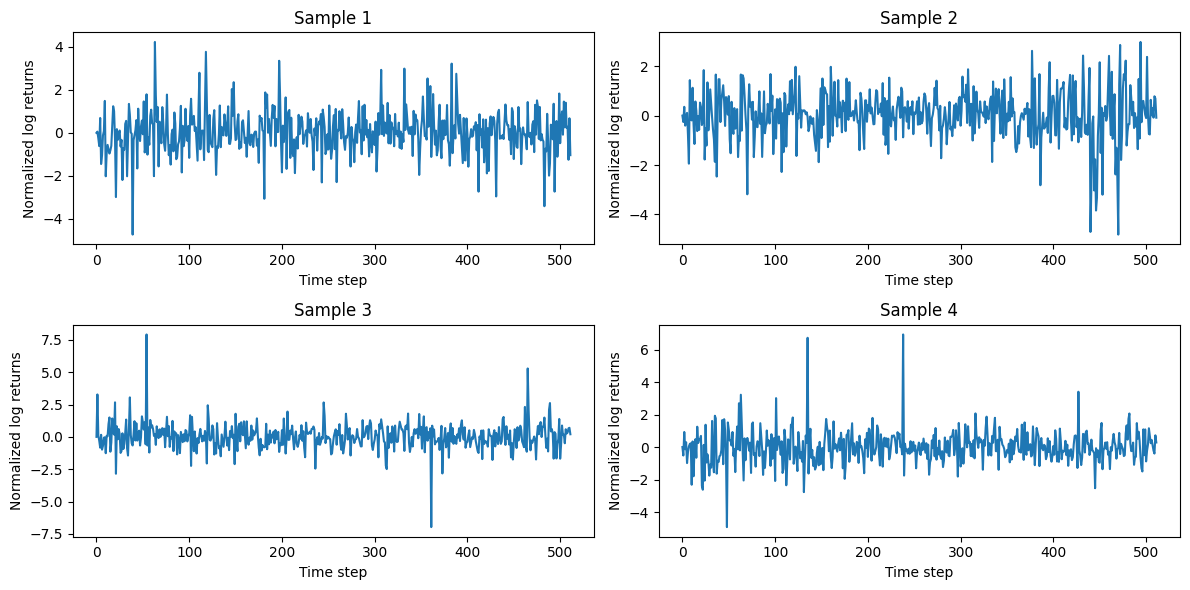

In [ ]:
!pip install -q yfinance

import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from tqdm import tqdm

class StockDataLoader:
    """Loads and serves real stock price data for SAE training."""

    # Large list of liquid US stocks (S&P 500 components + popular stocks)
    DEFAULT_TICKERS = [
        # Tech
        "AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA", "AMD", "INTC", "CRM",
        "ORCL", "ADBE", "CSCO", "AVGO", "TXN", "QCOM", "IBM", "NOW", "AMAT", "MU",
        "LRCX", "ADI", "KLAC", "SNPS", "CDNS", "MRVL", "FTNT", "PANW", "CRWD", "ZS",
        # Finance
        "JPM", "BAC", "WFC", "GS", "MS", "C", "BLK", "SCHW", "AXP", "USB",
        "PNC", "TFC", "BK", "STT", "FITB", "RF", "CFG", "KEY", "HBAN", "ZION",
        # Healthcare
        "JNJ", "UNH", "PFE", "MRK", "ABBV", "LLY", "TMO", "ABT", "DHR", "BMY",
        "AMGN", "GILD", "ISRG", "VRTX", "REGN", "MDT", "SYK", "BDX", "ZBH", "BSX",
        # Consumer
        "WMT", "PG", "KO", "PEP", "COST", "MCD", "NKE", "SBUX", "TGT", "LOW",
        "HD", "TJX", "ROST", "DG", "DLTR", "YUM", "CMG", "DPZ", "QSR", "WEN",
        # Industrial
        "CAT", "DE", "BA", "HON", "UPS", "UNP", "LMT", "RTX", "GE", "MMM",
        "EMR", "ETN", "PH", "ROK", "AME", "CMI", "PCAR", "FAST", "GWW", "SWK",
        # Energy
        "XOM", "CVX", "COP", "SLB", "EOG", "MPC", "PSX", "VLO", "OXY", "PXD",
        "DVN", "FANG", "HES", "HAL", "BKR", "KMI", "WMB", "OKE", "TRGP", "LNG",
        # Utilities & REITs
        "NEE", "DUK", "SO", "D", "AEP", "EXC", "SRE", "XEL", "ED", "WEC",
        "PLD", "AMT", "CCI", "EQIX", "PSA", "SPG", "O", "WELL", "AVB", "EQR",
        # Communications
        "DIS", "CMCSA", "NFLX", "T", "VZ", "TMUS", "CHTR", "EA", "ATVI", "TTWO",
        # Materials
        "LIN", "APD", "SHW", "ECL", "DD", "NEM", "FCX", "NUE", "VMC", "MLM",
    ]

    def __init__(
        self,
        seq_len: int = 512,
        device: str = "cpu",
        tickers: list = None,
        years: int = 10,
        price_col: str = "Close",
        normalize: bool = True,
    ):
        self.seq_len = seq_len
        self.device = device
        self.tickers = tickers or self.DEFAULT_TICKERS
        self.years = years
        self.price_col = price_col
        self.normalize = normalize

        # Storage for processed data
        self.windows = []
        self.ticker_labels = []

        # Download and process data
        self._download_data()

    def _download_data(self):
        """Download historical stock data and create sliding windows."""
        print(f"Downloading {len(self.tickers)} stocks, {self.years} years of data...")

        end_date = "2026-01-16"
        start_date = f"{2026 - self.years}-01-01"

        successful = 0
        failed = []

        for ticker in tqdm(self.tickers, desc="Downloading"):
            try:
                df = yf.download(
                    ticker,
                    start=start_date,
                    end=end_date,
                    progress=False,
                    auto_adjust=True,
                )

                if len(df) < self.seq_len + 100:  # Need enough data
                    failed.append(ticker)
                    continue

                prices = df[self.price_col].values.astype(np.float32)

                # Remove NaN values
                prices = prices[~np.isnan(prices)]

                if len(prices) < self.seq_len + 100:
                    failed.append(ticker)
                    continue

                # Create sliding windows
                windows = self._create_windows(prices, ticker)
                self.windows.extend(windows)
                successful += 1

            except Exception as e:
                failed.append(ticker)
                continue

        print(f"\nDownload complete:")
        print(f"  Successful: {successful} stocks")
        print(f"  Failed: {len(failed)} stocks")
        print(f"  Total windows: {len(self.windows):,}")
        print(f"  Data ready for training!")

        # Convert to tensor
        self.windows = torch.tensor(np.array(self.windows), dtype=torch.float32)

    def _create_windows(self, prices: np.ndarray, ticker: str) -> list:
        """Create sliding windows from price series."""
        windows = []

        # Use stride of seq_len//4 for overlap (more training data)
        stride = max(self.seq_len // 4, 50)

        for i in range(0, len(prices) - self.seq_len, stride):
            window = prices[i:i + self.seq_len].copy()

            if self.normalize:
                # Log returns normalization (standard for financial data)
                # Convert to log returns, then standardize
                log_prices = np.log(window + 1e-8)
                log_returns = np.diff(log_prices)

                # Pad to maintain length and standardize
                window = np.concatenate([[0], log_returns])

                # Standardize
                std = window.std()
                if std > 1e-8:
                    window = window / std

            windows.append(window)
            self.ticker_labels.append(ticker)

        return windows

    def generate_batch(self, batch_size: int) -> torch.Tensor:
        """
        Generate a random batch of stock price windows.

        Returns:
            (batch_size, seq_len) tensor
        """
        indices = torch.randint(0, len(self.windows), (batch_size,))
        batch = self.windows[indices]
        return batch.to(self.device)

    def get_sample_with_label(self, idx: int) -> tuple:
        """Get a specific sample with its ticker label."""
        return self.windows[idx], self.ticker_labels[idx]

# Load stock data
data_gen = StockDataLoader(
    seq_len=config.context_length,
    device=config.device,
    years=10,  # 10 years of historical data
)

# Visualize samples
print("\nSample stock windows:")
test_batch = data_gen.generate_batch(4)
print(f"Batch shape: {test_batch.shape}")

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.plot(test_batch[i].cpu().numpy())
    ax.set_title(f"Sample {i+1}")
    ax.set_xlabel("Time step")
    ax.set_ylabel("Normalized log returns")
plt.tight_layout()
plt.show()

## Cell 5: SAE Model (BatchTopK)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BatchTopKSAE(nn.Module):
    """
    Sparse Autoencoder with BatchTopK activation.

    Architecture:
        Encoder: x -> (x - b_dec) @ W_enc + b_enc -> top-k -> features
        Decoder: features @ W_dec + b_dec -> reconstruction
    """

    def __init__(self, d_in: int = 512, d_sae: int = 4096, k: int = 32):
        super().__init__()
        self.d_in = d_in
        self.d_sae = d_sae
        self.k = k

        # Encoder weights
        self.W_enc = nn.Parameter(torch.empty(d_in, d_sae))
        self.b_enc = nn.Parameter(torch.zeros(d_sae))

        # Decoder weights (will be unit normalized)
        self.W_dec = nn.Parameter(torch.empty(d_sae, d_in))
        self.b_dec = nn.Parameter(torch.zeros(d_in))

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights with appropriate scaling."""
        # Kaiming init for encoder
        nn.init.kaiming_uniform_(self.W_enc, a=np.sqrt(5))

        # Initialize decoder as transpose of encoder, then normalize
        with torch.no_grad():
            self.W_dec.data = self.W_enc.data.T.clone()
            self._normalize_decoder()

    def _normalize_decoder(self):
        """Normalize decoder columns to unit norm."""
        with torch.no_grad():
            norms = torch.norm(self.W_dec, dim=1, keepdim=True)
            self.W_dec.data = self.W_dec.data / (norms + 1e-8)

    def encode(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        """
        Encode input to sparse features using BatchTopK.

        Args:
            x: (batch, d_in) input activations

        Returns:
            features: (batch, d_sae) sparse feature activations
            top_indices: (batch, k) indices of active features
        """
        # Center input
        x_centered = x - self.b_dec

        # Pre-activations
        pre_acts = x_centered @ self.W_enc + self.b_enc  # (batch, d_sae)

        # Apply ReLU first
        pre_acts_relu = F.relu(pre_acts)

        # Get top-k values and indices
        top_values, top_indices = torch.topk(pre_acts_relu, self.k, dim=-1)

        # Create sparse output
        features = torch.zeros_like(pre_acts_relu)
        features.scatter_(dim=-1, index=top_indices, src=top_values)

        return features, top_indices

    def decode(self, features: torch.Tensor) -> torch.Tensor:
        """
        Decode sparse features back to input space.

        Args:
            features: (batch, d_sae) sparse feature activations

        Returns:
            reconstruction: (batch, d_in)
        """
        return features @ self.W_dec + self.b_dec

    def forward(self, x: torch.Tensor) -> dict:
        """
        Full forward pass with loss computation.

        Args:
            x: (batch, d_in) or (batch, seq, d_in) input activations

        Returns:
            dict with reconstruction, features, and losses
        """
        # Handle 3D input by flattening
        original_shape = x.shape
        if x.dim() == 3:
            batch, seq, d = x.shape
            x = x.reshape(-1, d)  # (batch * seq, d_in)

        # Encode and decode
        features, top_indices = self.encode(x)
        reconstruction = self.decode(features)

        # Compute losses
        mse_loss = F.mse_loss(reconstruction, x)

        # L0 sparsity (number of active features per sample)
        l0 = (features > 0).float().sum(dim=-1).mean()

        # Cosine similarity for reconstruction quality
        cos_sim = F.cosine_similarity(reconstruction, x, dim=-1).mean()

        # Reshape outputs if needed
        if len(original_shape) == 3:
            reconstruction = reconstruction.reshape(original_shape)
            features = features.reshape(batch, seq, -1)

        return {
            "reconstruction": reconstruction,
            "features": features,
            "mse_loss": mse_loss,
            "l0": l0,
            "cos_sim": cos_sim,
            "loss": mse_loss,  # Total loss (no L1 penalty with BatchTopK)
        }

# Test the SAE
sae = BatchTopKSAE(config.d_model, config.d_sae, config.k).to(config.device)
print(f"SAE parameters: {sum(p.numel() for p in sae.parameters()):,}")

# Test forward pass
test_input = torch.randn(4, 10, config.d_model).to(config.device)
output = sae(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Reconstruction shape: {output['reconstruction'].shape}")
print(f"Features shape: {output['features'].shape}")
print(f"MSE: {output['mse_loss']:.4f}, L0: {output['l0']:.1f}, Cos sim: {output['cos_sim']:.4f}")

SAE parameters: 4,198,912
Input shape: torch.Size([4, 10, 512])
Reconstruction shape: torch.Size([4, 10, 512])
Features shape: torch.Size([4, 10, 4096])
MSE: 0.8170, L0: 32.0, Cos sim: 0.5697


## Cell 6: Training Loop

In [ ]:
from tqdm import tqdm
import math
import os

class SAETrainer:
    """
    Trainer for SAE on Chronos activations.
    """

    def __init__(
        self,
        sae: BatchTopKSAE,
        extractor: ChronosActivationExtractor,
        data_gen: StockDataLoader,
        config: Config,
        checkpoint_dir: str = "/content/drive/MyDrive/sae_checkpoints"
    ):
        self.sae = sae
        self.extractor = extractor
        self.data_gen = data_gen
        self.config = config
        self.checkpoint_dir = checkpoint_dir

        # Optimizer
        self.optimizer = torch.optim.AdamW(
            sae.parameters(),
            lr=config.learning_rate,
            betas=(0.9, 0.999),
        )

        # Training state
        self.step = 0
        self.history = {
            "mse": [],
            "l0": [],
            "cos_sim": [],
            "lr": [],
        }

    def get_lr(self) -> float:
        """Linear warmup + cosine decay schedule."""
        if self.step < self.config.warmup_steps:
            # Linear warmup
            return self.config.learning_rate * self.step / self.config.warmup_steps
        else:
            # Cosine decay
            progress = (self.step - self.config.warmup_steps) / (
                self.config.total_steps - self.config.warmup_steps
            )
            return self.config.learning_rate * 0.5 * (1 + math.cos(math.pi * progress))

    def set_lr(self, lr: float):
        """Update optimizer learning rate."""
        for param_group in self.optimizer.param_groups:
            param_group["lr"] = lr

    @torch.no_grad()
    def collect_activations(self, target_size: int) -> torch.Tensor:
        """
        Collect activations until we have enough for a training batch.

        Returns:
            activations: (target_size, d_model) tensor
        """
        all_acts = []
        total = 0

        while total < target_size:
            # Generate time series batch
            ts_batch = self.data_gen.generate_batch(self.config.batch_size)

            # Extract activations
            acts = self.extractor.extract(ts_batch)  # (batch, seq, d_model)

            # Flatten to (batch * seq, d_model)
            acts_flat = acts.reshape(-1, self.config.d_model)
            all_acts.append(acts_flat)
            total += acts_flat.shape[0]

        # Concatenate and trim to target size
        activations = torch.cat(all_acts, dim=0)[:target_size]
        return activations

    def train_step(self) -> dict:
        """Perform a single training step."""
        self.sae.train()

        # Update learning rate
        lr = self.get_lr()
        self.set_lr(lr)

        # Collect activations
        activations = self.collect_activations(self.config.activation_batch_size)

        # Forward pass
        output = self.sae(activations)
        loss = output["loss"]

        # Backward pass
        self.optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(self.sae.parameters(), self.config.grad_clip)

        # Update
        self.optimizer.step()

        # Normalize decoder
        self.sae._normalize_decoder()

        # Record metrics
        metrics = {
            "mse": output["mse_loss"].item(),
            "l0": output["l0"].item(),
            "cos_sim": output["cos_sim"].item(),
            "lr": lr,
        }

        self.step += 1
        return metrics

    def save_checkpoint(self, path: str = None):
        """Save training checkpoint."""
        if path is None:
            os.makedirs(self.checkpoint_dir, exist_ok=True)
            path = os.path.join(self.checkpoint_dir, f"sae_step_{self.step}.pt")

        checkpoint = {
            "step": self.step,
            "sae_state_dict": self.sae.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "history": self.history,
            "config": self.config,
        }
        torch.save(checkpoint, path)
        print(f"Checkpoint saved to {path}")

    def load_checkpoint(self, path: str):
        """Load training checkpoint."""
        checkpoint = torch.load(path, map_location=self.config.device)
        self.step = checkpoint["step"]
        self.sae.load_state_dict(checkpoint["sae_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.history = checkpoint["history"]
        print(f"Loaded checkpoint from step {self.step}")

    def train(self):
        """Run full training loop."""
        print(f"Starting training for {self.config.total_steps} steps...")
        print(f"Batch size: {self.config.activation_batch_size} activations")
        print(f"SAE: {self.config.d_model} -> {self.config.d_sae} (k={self.config.k})")
        print("-" * 60)

        pbar = tqdm(range(self.step, self.config.total_steps), desc="Training")

        for _ in pbar:
            metrics = self.train_step()

            # Update progress bar
            pbar.set_postfix(
                mse=f"{metrics['mse']:.4f}",
                l0=f"{metrics['l0']:.1f}",
                cos=f"{metrics['cos_sim']:.3f}"
            )

            # Log metrics
            if self.step % self.config.log_every == 0:
                for key, value in metrics.items():
                    self.history[key].append(value)

                print(f"\nStep {self.step}: MSE={metrics['mse']:.4f}, "
                      f"L0={metrics['l0']:.1f}, Cos={metrics['cos_sim']:.3f}, "
                      f"LR={metrics['lr']:.2e}")

            # Save checkpoint
            if self.step % self.config.checkpoint_every == 0:
                self.save_checkpoint()

            # Clear cache periodically
            if self.step % 500 == 0:
                torch.cuda.empty_cache()

        # Final checkpoint
        self.save_checkpoint(os.path.join(self.checkpoint_dir, "sae_final.pt"))
        print("\nTraining complete!")

print("Trainer class defined.")

Trainer class defined.


## Cell 7: Run Training

In [ ]:
# Mount Google Drive for checkpoints (uncomment in Colab)
# from google.colab import drive
# drive.mount('/content/drive')

# For local testing, use a local directory
checkpoint_dir = "./sae_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# Create trainer
trainer = SAETrainer(
    sae=sae,
    extractor=extractor,
    data_gen=data_gen,
    config=config,
    checkpoint_dir=checkpoint_dir
)

# Optional: Load from checkpoint
# trainer.load_checkpoint("path/to/checkpoint.pt")

# Check GPU memory before training
if torch.cuda.is_available():
    print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"GPU memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

GPU memory allocated: 0.12 GB
GPU memory reserved: 0.20 GB


In [ ]:
# Smoke test: Run a few steps to verify everything works
print("Running smoke test (10 steps)...")

# Run smoke test
for i in range(10):
    metrics = trainer.train_step()
    if i % 5 == 0:
        print(f"Step {trainer.step}: MSE={metrics['mse']:.4f}, L0={metrics['l0']:.1f}, cos_sim={metrics['cos_sim']:.4f}")

print("\nSmoke test passed! Ready for full training.")
if torch.cuda.is_available():
    print(f"GPU memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")

Running smoke test (10 steps)...
Step 1: MSE=11.0457, L0=32.0, cos_sim=0.5799
Step 6: MSE=10.0631, L0=32.0, cos_sim=0.5773

Smoke test passed! Ready for full training.
GPU memory: 0.20 GB


In [ ]:
# Full training (uncomment to run)
config.total_steps = 10000
trainer.config = config
trainer.train()

Starting training for 10000 steps...
Batch size: 2048 activations
SAE: 512 -> 4096 (k=32)
------------------------------------------------------------


Training:   1%|          | 90/9990 [01:07<2:03:12,  1.34it/s, cos=0.622, l0=32.0, mse=9.0982]


Step 100: MSE=9.0982, L0=32.0, Cos=0.622, LR=1.98e-05


Training:   2%|▏         | 190/9990 [02:22<2:02:29,  1.33it/s, cos=0.704, l0=32.0, mse=6.6769]


Step 200: MSE=6.6769, L0=32.0, Cos=0.704, LR=3.98e-05


Training:   3%|▎         | 290/9990 [03:37<2:01:08,  1.33it/s, cos=0.864, l0=32.0, mse=3.3728]


Step 300: MSE=3.3728, L0=32.0, Cos=0.864, LR=5.98e-05


Training:   4%|▍         | 390/9990 [04:52<1:59:42,  1.34it/s, cos=0.908, l0=32.0, mse=2.5149]


Step 400: MSE=2.5149, L0=32.0, Cos=0.908, LR=7.98e-05


Training:   5%|▍         | 490/9990 [06:07<1:58:51,  1.33it/s, cos=0.895, l0=32.0, mse=2.4384]


Step 500: MSE=2.4384, L0=32.0, Cos=0.895, LR=9.98e-05


Training:   6%|▌         | 590/9990 [07:21<1:57:16,  1.34it/s, cos=0.926, l0=32.0, mse=1.8851]


Step 600: MSE=1.8851, L0=32.0, Cos=0.926, LR=1.00e-04


Training:   7%|▋         | 690/9990 [08:36<1:56:01,  1.34it/s, cos=0.941, l0=32.0, mse=1.4627]


Step 700: MSE=1.4627, L0=32.0, Cos=0.941, LR=9.99e-05


Training:   8%|▊         | 790/9990 [09:51<1:54:47,  1.34it/s, cos=0.935, l0=32.0, mse=1.5284]


Step 800: MSE=1.5284, L0=32.0, Cos=0.935, LR=9.98e-05


Training:   9%|▉         | 890/9990 [11:06<1:53:34,  1.34it/s, cos=0.944, l0=32.0, mse=1.3282]


Step 900: MSE=1.3282, L0=32.0, Cos=0.944, LR=9.96e-05


Training:  10%|▉         | 990/9990 [12:21<1:52:38,  1.33it/s, cos=0.946, l0=32.0, mse=1.2763]


Step 1000: MSE=1.2763, L0=32.0, Cos=0.946, LR=9.93e-05


Training:  11%|█         | 1090/9990 [13:36<1:51:02,  1.34it/s, cos=0.962, l0=32.0, mse=0.9708]


Step 1100: MSE=0.9708, L0=32.0, Cos=0.962, LR=9.90e-05


Training:  12%|█▏        | 1190/9990 [14:51<1:50:08,  1.33it/s, cos=0.958, l0=32.0, mse=1.0695]


Step 1200: MSE=1.0695, L0=32.0, Cos=0.958, LR=9.87e-05


Training:  13%|█▎        | 1290/9990 [16:05<1:48:25,  1.34it/s, cos=0.958, l0=32.0, mse=1.0466]


Step 1300: MSE=1.0466, L0=32.0, Cos=0.958, LR=9.83e-05


Training:  14%|█▍        | 1390/9990 [17:20<1:47:11,  1.34it/s, cos=0.961, l0=32.0, mse=0.9101]


Step 1400: MSE=0.9101, L0=32.0, Cos=0.961, LR=9.78e-05


Training:  15%|█▍        | 1490/9990 [18:35<1:46:24,  1.33it/s, cos=0.960, l0=32.0, mse=1.0241]


Step 1500: MSE=1.0241, L0=32.0, Cos=0.960, LR=9.73e-05


Training:  16%|█▌        | 1590/9990 [19:50<1:44:46,  1.34it/s, cos=0.967, l0=32.0, mse=0.8537]


Step 1600: MSE=0.8537, L0=32.0, Cos=0.967, LR=9.67e-05


Training:  17%|█▋        | 1690/9990 [21:05<1:43:31,  1.34it/s, cos=0.964, l0=32.0, mse=0.9423]


Step 1700: MSE=0.9423, L0=32.0, Cos=0.964, LR=9.61e-05


Training:  18%|█▊        | 1790/9990 [22:20<1:42:16,  1.34it/s, cos=0.968, l0=32.0, mse=0.7884]


Step 1800: MSE=0.7884, L0=32.0, Cos=0.968, LR=9.55e-05


Training:  19%|█▉        | 1890/9990 [23:34<1:40:59,  1.34it/s, cos=0.973, l0=32.0, mse=0.6958]


Step 1900: MSE=0.6958, L0=32.0, Cos=0.973, LR=9.47e-05


Training:  20%|█▉        | 1990/9990 [24:49<1:43:10,  1.29it/s, cos=0.971, l0=32.0, mse=0.7083]


Step 2000: MSE=0.7083, L0=32.0, Cos=0.971, LR=9.40e-05
Checkpoint saved to ./sae_checkpoints/sae_step_2000.pt


Training:  21%|██        | 2090/9990 [26:04<1:38:45,  1.33it/s, cos=0.968, l0=32.0, mse=0.7791]


Step 2100: MSE=0.7791, L0=32.0, Cos=0.968, LR=9.32e-05


Training:  22%|██▏       | 2190/9990 [27:19<1:37:17,  1.34it/s, cos=0.974, l0=32.0, mse=0.6821]


Step 2200: MSE=0.6821, L0=32.0, Cos=0.974, LR=9.23e-05


Training:  23%|██▎       | 2290/9990 [28:34<1:36:24,  1.33it/s, cos=0.976, l0=32.0, mse=0.6193]


Step 2300: MSE=0.6193, L0=32.0, Cos=0.976, LR=9.14e-05


Training:  24%|██▍       | 2390/9990 [29:49<1:35:03,  1.33it/s, cos=0.970, l0=32.0, mse=0.6997]


Step 2400: MSE=0.6997, L0=32.0, Cos=0.970, LR=9.05e-05


Training:  25%|██▍       | 2490/9990 [31:04<1:33:47,  1.33it/s, cos=0.974, l0=32.0, mse=0.6265]


Step 2500: MSE=0.6265, L0=32.0, Cos=0.974, LR=8.95e-05


Training:  26%|██▌       | 2590/9990 [32:19<1:32:19,  1.34it/s, cos=0.975, l0=32.0, mse=0.6568]


Step 2600: MSE=0.6568, L0=32.0, Cos=0.975, LR=8.84e-05


Training:  27%|██▋       | 2690/9990 [33:34<1:31:04,  1.34it/s, cos=0.974, l0=32.0, mse=0.6341]


Step 2700: MSE=0.6341, L0=32.0, Cos=0.974, LR=8.74e-05


Training:  28%|██▊       | 2790/9990 [34:49<1:29:48,  1.34it/s, cos=0.973, l0=32.0, mse=0.7464]


Step 2800: MSE=0.7464, L0=32.0, Cos=0.973, LR=8.62e-05


Training:  29%|██▉       | 2890/9990 [36:03<1:28:38,  1.33it/s, cos=0.975, l0=32.0, mse=0.6214]


Step 2900: MSE=0.6214, L0=32.0, Cos=0.975, LR=8.51e-05


Training:  30%|██▉       | 2990/9990 [37:18<1:27:40,  1.33it/s, cos=0.973, l0=32.0, mse=0.6835]


Step 3000: MSE=0.6835, L0=32.0, Cos=0.973, LR=8.39e-05


Training:  31%|███       | 3090/9990 [38:33<1:26:34,  1.33it/s, cos=0.973, l0=32.0, mse=0.6503]


Step 3100: MSE=0.6503, L0=32.0, Cos=0.973, LR=8.26e-05


Training:  32%|███▏      | 3190/9990 [39:49<1:25:23,  1.33it/s, cos=0.976, l0=32.0, mse=0.6106]


Step 3200: MSE=0.6106, L0=32.0, Cos=0.976, LR=8.14e-05


Training:  33%|███▎      | 3290/9990 [41:04<1:24:25,  1.32it/s, cos=0.977, l0=32.0, mse=0.5726]


Step 3300: MSE=0.5726, L0=32.0, Cos=0.977, LR=8.01e-05


Training:  34%|███▍      | 3390/9990 [42:19<1:22:13,  1.34it/s, cos=0.977, l0=32.0, mse=0.5825]


Step 3400: MSE=0.5825, L0=32.0, Cos=0.977, LR=7.87e-05


Training:  35%|███▍      | 3490/9990 [43:34<1:21:28,  1.33it/s, cos=0.975, l0=32.0, mse=0.6037]


Step 3500: MSE=0.6037, L0=32.0, Cos=0.975, LR=7.74e-05


Training:  36%|███▌      | 3590/9990 [44:49<1:19:47,  1.34it/s, cos=0.979, l0=32.0, mse=0.5569]


Step 3600: MSE=0.5569, L0=32.0, Cos=0.979, LR=7.60e-05


Training:  37%|███▋      | 3690/9990 [46:04<1:18:34,  1.34it/s, cos=0.977, l0=32.0, mse=0.5872]


Step 3700: MSE=0.5872, L0=32.0, Cos=0.977, LR=7.45e-05


Training:  38%|███▊      | 3790/9990 [47:19<1:17:22,  1.34it/s, cos=0.980, l0=32.0, mse=0.5232]


Step 3800: MSE=0.5232, L0=32.0, Cos=0.980, LR=7.31e-05


Training:  39%|███▉      | 3890/9990 [48:33<1:16:07,  1.34it/s, cos=0.978, l0=32.0, mse=0.5339]


Step 3900: MSE=0.5339, L0=32.0, Cos=0.978, LR=7.16e-05


Training:  40%|███▉      | 3990/9990 [49:48<1:16:35,  1.31it/s, cos=0.979, l0=32.0, mse=0.5176]


Step 4000: MSE=0.5176, L0=32.0, Cos=0.979, LR=7.01e-05
Checkpoint saved to ./sae_checkpoints/sae_step_4000.pt


Training:  41%|████      | 4090/9990 [51:03<1:13:34,  1.34it/s, cos=0.980, l0=32.0, mse=0.5249]


Step 4100: MSE=0.5249, L0=32.0, Cos=0.980, LR=6.86e-05


Training:  42%|████▏     | 4190/9990 [52:18<1:12:15,  1.34it/s, cos=0.979, l0=32.0, mse=0.4924]


Step 4200: MSE=0.4924, L0=32.0, Cos=0.979, LR=6.70e-05


Training:  43%|████▎     | 4290/9990 [53:33<1:11:02,  1.34it/s, cos=0.981, l0=32.0, mse=0.5378]


Step 4300: MSE=0.5378, L0=32.0, Cos=0.981, LR=6.55e-05


Training:  44%|████▍     | 4390/9990 [54:48<1:09:52,  1.34it/s, cos=0.978, l0=32.0, mse=0.5563]


Step 4400: MSE=0.5563, L0=32.0, Cos=0.978, LR=6.39e-05


Training:  45%|████▍     | 4490/9990 [56:02<1:08:47,  1.33it/s, cos=0.981, l0=32.0, mse=0.4781]


Step 4500: MSE=0.4781, L0=32.0, Cos=0.981, LR=6.23e-05


Training:  46%|████▌     | 4590/9990 [57:17<1:07:20,  1.34it/s, cos=0.980, l0=32.0, mse=0.4879]


Step 4600: MSE=0.4879, L0=32.0, Cos=0.980, LR=6.07e-05


Training:  47%|████▋     | 4690/9990 [58:32<1:06:07,  1.34it/s, cos=0.976, l0=32.0, mse=0.5940]


Step 4700: MSE=0.5940, L0=32.0, Cos=0.976, LR=5.91e-05


Training:  48%|████▊     | 4790/9990 [59:47<1:04:53,  1.34it/s, cos=0.978, l0=32.0, mse=0.5209]


Step 4800: MSE=0.5209, L0=32.0, Cos=0.978, LR=5.74e-05


Training:  49%|████▉     | 4890/9990 [1:01:02<1:03:35,  1.34it/s, cos=0.977, l0=32.0, mse=0.5809]


Step 4900: MSE=0.5809, L0=32.0, Cos=0.977, LR=5.58e-05


Training:  50%|████▉     | 4990/9990 [1:02:17<1:02:32,  1.33it/s, cos=0.979, l0=32.0, mse=0.5815]


Step 5000: MSE=0.5815, L0=32.0, Cos=0.979, LR=5.41e-05


Training:  51%|█████     | 5090/9990 [1:03:31<1:01:05,  1.34it/s, cos=0.980, l0=32.0, mse=0.4875]


Step 5100: MSE=0.4875, L0=32.0, Cos=0.980, LR=5.25e-05


Training:  52%|█████▏    | 5190/9990 [1:04:46<59:52,  1.34it/s, cos=0.979, l0=32.0, mse=0.4983]


Step 5200: MSE=0.4983, L0=32.0, Cos=0.979, LR=5.08e-05


Training:  53%|█████▎    | 5290/9990 [1:06:01<58:40,  1.33it/s, cos=0.978, l0=32.0, mse=0.5388]


Step 5300: MSE=0.5388, L0=32.0, Cos=0.978, LR=4.92e-05


Training:  54%|█████▍    | 5390/9990 [1:07:16<57:17,  1.34it/s, cos=0.980, l0=32.0, mse=0.5508]


Step 5400: MSE=0.5508, L0=32.0, Cos=0.980, LR=4.75e-05


Training:  55%|█████▍    | 5490/9990 [1:08:31<56:14,  1.33it/s, cos=0.982, l0=32.0, mse=0.4514]


Step 5500: MSE=0.4514, L0=32.0, Cos=0.982, LR=4.59e-05


Training:  56%|█████▌    | 5590/9990 [1:09:46<54:55,  1.34it/s, cos=0.982, l0=32.0, mse=0.4522]


Step 5600: MSE=0.4522, L0=32.0, Cos=0.982, LR=4.42e-05


Training:  57%|█████▋    | 5690/9990 [1:11:00<53:37,  1.34it/s, cos=0.980, l0=32.0, mse=0.4967]


Step 5700: MSE=0.4967, L0=32.0, Cos=0.980, LR=4.26e-05


Training:  58%|█████▊    | 5790/9990 [1:12:15<52:22,  1.34it/s, cos=0.980, l0=32.0, mse=0.5026]


Step 5800: MSE=0.5026, L0=32.0, Cos=0.980, LR=4.10e-05


Training:  59%|█████▉    | 5890/9990 [1:13:30<51:09,  1.34it/s, cos=0.980, l0=32.0, mse=0.4934]


Step 5900: MSE=0.4934, L0=32.0, Cos=0.980, LR=3.94e-05


Training:  60%|█████▉    | 5990/9990 [1:14:45<51:14,  1.30it/s, cos=0.979, l0=32.0, mse=0.5135]


Step 6000: MSE=0.5135, L0=32.0, Cos=0.979, LR=3.77e-05
Checkpoint saved to ./sae_checkpoints/sae_step_6000.pt


Training:  61%|██████    | 6090/9990 [1:16:00<48:39,  1.34it/s, cos=0.981, l0=32.0, mse=0.4988]


Step 6100: MSE=0.4988, L0=32.0, Cos=0.981, LR=3.61e-05


Training:  62%|██████▏   | 6190/9990 [1:17:15<47:23,  1.34it/s, cos=0.980, l0=32.0, mse=0.5095]


Step 6200: MSE=0.5095, L0=32.0, Cos=0.980, LR=3.46e-05


Training:  63%|██████▎   | 6290/9990 [1:18:29<46:07,  1.34it/s, cos=0.981, l0=32.0, mse=0.4760]


Step 6300: MSE=0.4760, L0=32.0, Cos=0.981, LR=3.30e-05


Training:  64%|██████▍   | 6390/9990 [1:19:44<44:52,  1.34it/s, cos=0.982, l0=32.0, mse=0.4444]


Step 6400: MSE=0.4444, L0=32.0, Cos=0.982, LR=3.15e-05


Training:  65%|██████▍   | 6490/9990 [1:20:59<43:50,  1.33it/s, cos=0.979, l0=32.0, mse=0.4924]


Step 6500: MSE=0.4924, L0=32.0, Cos=0.979, LR=2.99e-05


Training:  66%|██████▌   | 6590/9990 [1:22:14<42:24,  1.34it/s, cos=0.981, l0=32.0, mse=0.5128]


Step 6600: MSE=0.5128, L0=32.0, Cos=0.981, LR=2.84e-05


Training:  67%|██████▋   | 6690/9990 [1:23:29<41:09,  1.34it/s, cos=0.980, l0=32.0, mse=0.5036]


Step 6700: MSE=0.5036, L0=32.0, Cos=0.980, LR=2.69e-05


Training:  68%|██████▊   | 6790/9990 [1:24:44<39:53,  1.34it/s, cos=0.983, l0=32.0, mse=0.4424]


Step 6800: MSE=0.4424, L0=32.0, Cos=0.983, LR=2.55e-05


Training:  69%|██████▉   | 6890/9990 [1:25:59<38:41,  1.34it/s, cos=0.980, l0=32.0, mse=0.4776]


Step 6900: MSE=0.4776, L0=32.0, Cos=0.980, LR=2.41e-05


Training:  70%|██████▉   | 6990/9990 [1:27:13<37:32,  1.33it/s, cos=0.980, l0=32.0, mse=0.5140]


Step 7000: MSE=0.5140, L0=32.0, Cos=0.980, LR=2.27e-05


Training:  71%|███████   | 7090/9990 [1:28:28<36:09,  1.34it/s, cos=0.982, l0=32.0, mse=0.5066]


Step 7100: MSE=0.5066, L0=32.0, Cos=0.982, LR=2.13e-05


Training:  72%|███████▏  | 7190/9990 [1:29:43<34:53,  1.34it/s, cos=0.980, l0=32.0, mse=0.4800]


Step 7200: MSE=0.4800, L0=32.0, Cos=0.980, LR=2.00e-05


Training:  73%|███████▎  | 7290/9990 [1:30:58<33:39,  1.34it/s, cos=0.980, l0=32.0, mse=0.5281]


Step 7300: MSE=0.5281, L0=32.0, Cos=0.980, LR=1.87e-05


Training:  74%|███████▍  | 7390/9990 [1:32:13<32:26,  1.34it/s, cos=0.980, l0=32.0, mse=0.5348]


Step 7400: MSE=0.5348, L0=32.0, Cos=0.980, LR=1.74e-05


Training:  75%|███████▍  | 7490/9990 [1:33:28<31:18,  1.33it/s, cos=0.981, l0=32.0, mse=0.4809]


Step 7500: MSE=0.4809, L0=32.0, Cos=0.981, LR=1.61e-05


Training:  76%|███████▌  | 7590/9990 [1:34:42<29:57,  1.34it/s, cos=0.979, l0=32.0, mse=0.4989]


Step 7600: MSE=0.4989, L0=32.0, Cos=0.979, LR=1.49e-05


Training:  77%|███████▋  | 7690/9990 [1:35:57<28:43,  1.33it/s, cos=0.982, l0=32.0, mse=0.4503]


Step 7700: MSE=0.4503, L0=32.0, Cos=0.982, LR=1.38e-05


Training:  78%|███████▊  | 7790/9990 [1:37:12<27:25,  1.34it/s, cos=0.982, l0=32.0, mse=0.4411]


Step 7800: MSE=0.4411, L0=32.0, Cos=0.982, LR=1.27e-05


Training:  79%|███████▉  | 7890/9990 [1:38:27<26:10,  1.34it/s, cos=0.982, l0=32.0, mse=0.4589]


Step 7900: MSE=0.4589, L0=32.0, Cos=0.982, LR=1.16e-05


Training:  80%|███████▉  | 7990/9990 [1:39:42<25:36,  1.30it/s, cos=0.981, l0=32.0, mse=0.4805]


Step 8000: MSE=0.4805, L0=32.0, Cos=0.981, LR=1.06e-05
Checkpoint saved to ./sae_checkpoints/sae_step_8000.pt


Training:  81%|████████  | 8090/9990 [1:40:57<23:41,  1.34it/s, cos=0.981, l0=32.0, mse=0.4652]


Step 8100: MSE=0.4652, L0=32.0, Cos=0.981, LR=9.56e-06


Training:  82%|████████▏ | 8190/9990 [1:42:12<22:26,  1.34it/s, cos=0.981, l0=32.0, mse=0.4847]


Step 8200: MSE=0.4847, L0=32.0, Cos=0.981, LR=8.61e-06


Training:  83%|████████▎ | 8290/9990 [1:43:26<21:13,  1.33it/s, cos=0.983, l0=32.0, mse=0.4369]


Step 8300: MSE=0.4369, L0=32.0, Cos=0.983, LR=7.70e-06


Training:  84%|████████▍ | 8390/9990 [1:44:41<19:57,  1.34it/s, cos=0.980, l0=32.0, mse=0.4941]


Step 8400: MSE=0.4941, L0=32.0, Cos=0.980, LR=6.85e-06


Training:  85%|████████▍ | 8490/9990 [1:45:56<18:45,  1.33it/s, cos=0.983, l0=32.0, mse=0.4336]


Step 8500: MSE=0.4336, L0=32.0, Cos=0.983, LR=6.03e-06


Training:  86%|████████▌ | 8590/9990 [1:47:11<17:27,  1.34it/s, cos=0.980, l0=32.0, mse=0.4950]


Step 8600: MSE=0.4950, L0=32.0, Cos=0.980, LR=5.27e-06


Training:  87%|████████▋ | 8690/9990 [1:48:26<16:13,  1.34it/s, cos=0.983, l0=32.0, mse=0.4692]


Step 8700: MSE=0.4692, L0=32.0, Cos=0.983, LR=4.56e-06


Training:  88%|████████▊ | 8790/9990 [1:49:41<14:58,  1.34it/s, cos=0.980, l0=32.0, mse=0.4723]


Step 8800: MSE=0.4723, L0=32.0, Cos=0.980, LR=3.89e-06


Training:  89%|████████▉ | 8890/9990 [1:50:56<13:42,  1.34it/s, cos=0.980, l0=32.0, mse=0.4790]


Step 8900: MSE=0.4790, L0=32.0, Cos=0.980, LR=3.28e-06


Training:  90%|████████▉ | 8990/9990 [1:52:10<12:29,  1.33it/s, cos=0.984, l0=32.0, mse=0.4068]


Step 9000: MSE=0.4068, L0=32.0, Cos=0.984, LR=2.71e-06


Training:  91%|█████████ | 9090/9990 [1:53:25<11:13,  1.34it/s, cos=0.980, l0=32.0, mse=0.5032]


Step 9100: MSE=0.5032, L0=32.0, Cos=0.980, LR=2.20e-06


Training:  92%|█████████▏| 9190/9990 [1:54:40<09:58,  1.34it/s, cos=0.981, l0=32.0, mse=0.4929]


Step 9200: MSE=0.4929, L0=32.0, Cos=0.981, LR=1.74e-06


Training:  93%|█████████▎| 9290/9990 [1:55:55<08:43,  1.34it/s, cos=0.981, l0=32.0, mse=0.4672]


Step 9300: MSE=0.4672, L0=32.0, Cos=0.981, LR=1.34e-06


Training:  94%|█████████▍| 9390/9990 [1:57:10<07:29,  1.33it/s, cos=0.983, l0=32.0, mse=0.4138]


Step 9400: MSE=0.4138, L0=32.0, Cos=0.983, LR=9.84e-07


Training:  95%|█████████▍| 9490/9990 [1:58:25<06:15,  1.33it/s, cos=0.981, l0=32.0, mse=0.5048]


Step 9500: MSE=0.5048, L0=32.0, Cos=0.981, LR=6.85e-07


Training:  96%|█████████▌| 9590/9990 [1:59:39<04:59,  1.34it/s, cos=0.979, l0=32.0, mse=0.4638]


Step 9600: MSE=0.4638, L0=32.0, Cos=0.979, LR=4.39e-07


Training:  96%|█████████▋| 9616/9990 [1:59:59<04:40,  1.34it/s, cos=0.981, l0=32.0, mse=0.5068]

## Cell 8: Evaluation & Visualization

In [ ]:
def plot_training_curves(history: dict):
    """Plot training metrics over time."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    # MSE Loss
    axes[0, 0].plot(history["mse"])
    axes[0, 0].set_title("MSE Loss")
    axes[0, 0].set_xlabel("Log Step")
    axes[0, 0].set_ylabel("MSE")
    axes[0, 0].set_yscale("log")

    # L0 Sparsity
    axes[0, 1].plot(history["l0"])
    axes[0, 1].axhline(y=config.k, color="r", linestyle="--", label=f"Target k={config.k}")
    axes[0, 1].set_title("L0 Sparsity")
    axes[0, 1].set_xlabel("Log Step")
    axes[0, 1].set_ylabel("Active Features")
    axes[0, 1].legend()

    # Cosine Similarity
    axes[1, 0].plot(history["cos_sim"])
    axes[1, 0].set_title("Reconstruction Cosine Similarity")
    axes[1, 0].set_xlabel("Log Step")
    axes[1, 0].set_ylabel("Cosine Similarity")
    axes[1, 0].set_ylim(0, 1)

    # Learning Rate
    axes[1, 1].plot(history["lr"])
    axes[1, 1].set_title("Learning Rate")
    axes[1, 1].set_xlabel("Log Step")
    axes[1, 1].set_ylabel("LR")

    plt.tight_layout()
    plt.show()

# Plot if we have history
if trainer.history["mse"]:
    plot_training_curves(trainer.history)

NameError: name 'trainer' is not defined

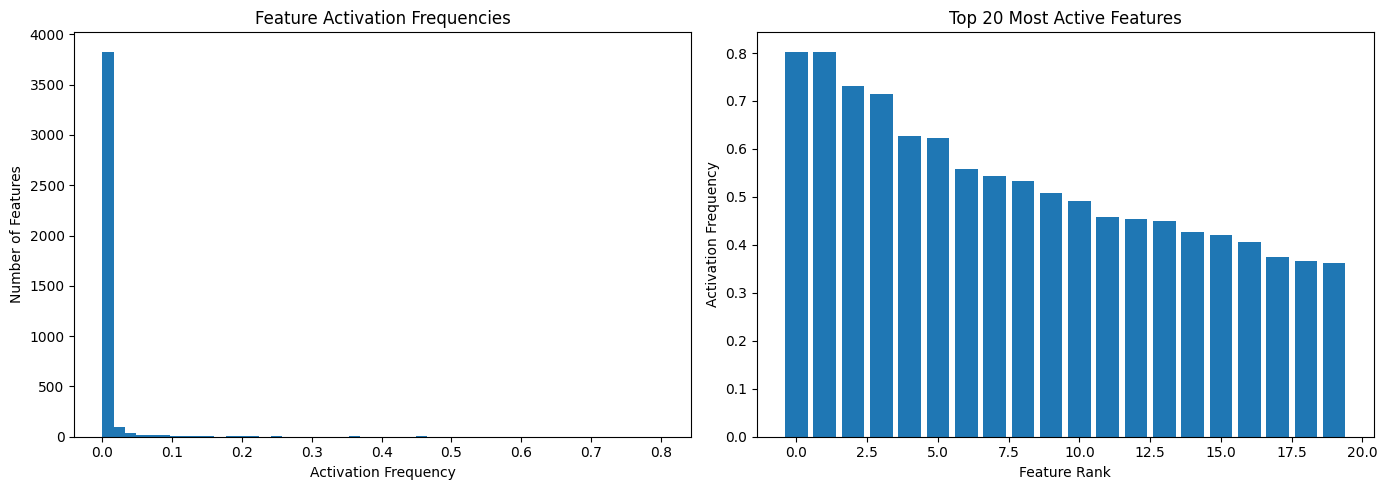

In [ ]:
@torch.no_grad()
def analyze_feature_activations(sae, extractor, data_gen, n_samples=100):
    """Analyze which features activate most frequently."""
    sae.eval()

    # Collect activations
    all_features = []
    for _ in range(n_samples // config.batch_size + 1):
        ts_batch = data_gen.generate_batch(config.batch_size)
        acts = extractor.extract(ts_batch)
        output = sae(acts)
        all_features.append(output["features"].reshape(-1, config.d_sae))

    features = torch.cat(all_features, dim=0)

    # Feature activation frequencies
    activation_freq = (features > 0).float().mean(dim=0)

    # Plot histogram
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Activation frequency histogram
    axes[0].hist(activation_freq.cpu().numpy(), bins=50)
    axes[0].set_title("Feature Activation Frequencies")
    axes[0].set_xlabel("Activation Frequency")
    axes[0].set_ylabel("Number of Features")

    # Top features
    top_features = torch.argsort(activation_freq, descending=True)[:20]
    axes[1].bar(range(20), activation_freq[top_features].cpu().numpy())
    axes[1].set_title("Top 20 Most Active Features")
    axes[1].set_xlabel("Feature Rank")
    axes[1].set_ylabel("Activation Frequency")

    plt.tight_layout()
    plt.show()

    return activation_freq, top_features

# Run analysis
activation_freq, top_features = analyze_feature_activations(sae, extractor, data_gen)

Analyzing top activating features...

Feature 3911 (rank 1):


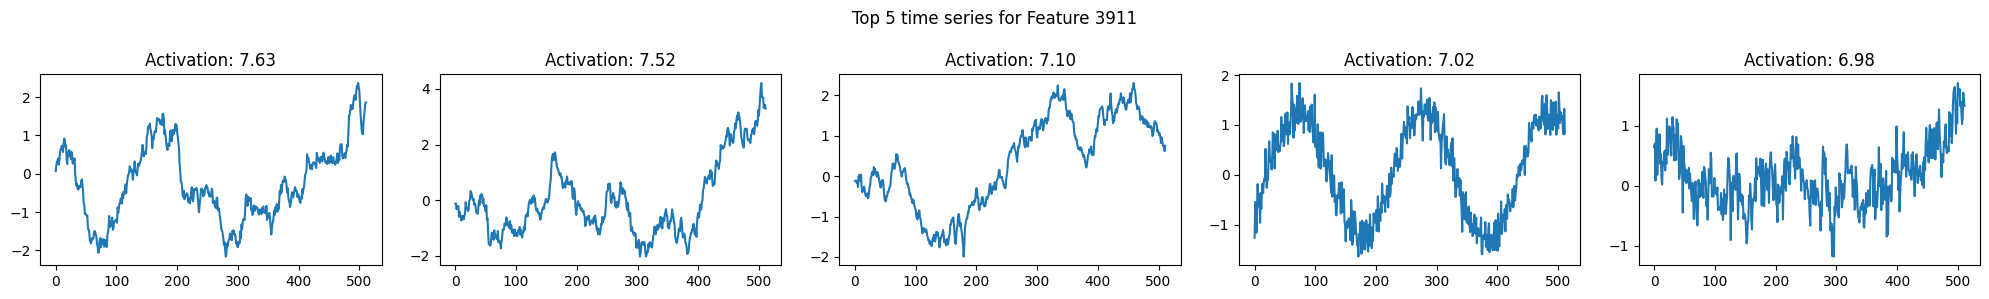


Feature 3098 (rank 2):


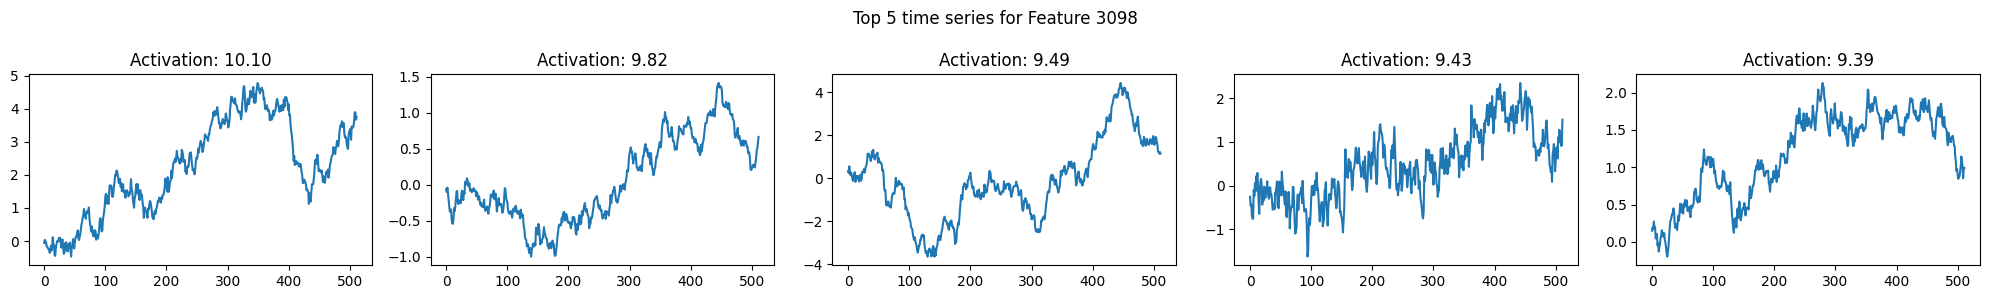


Feature 67 (rank 3):


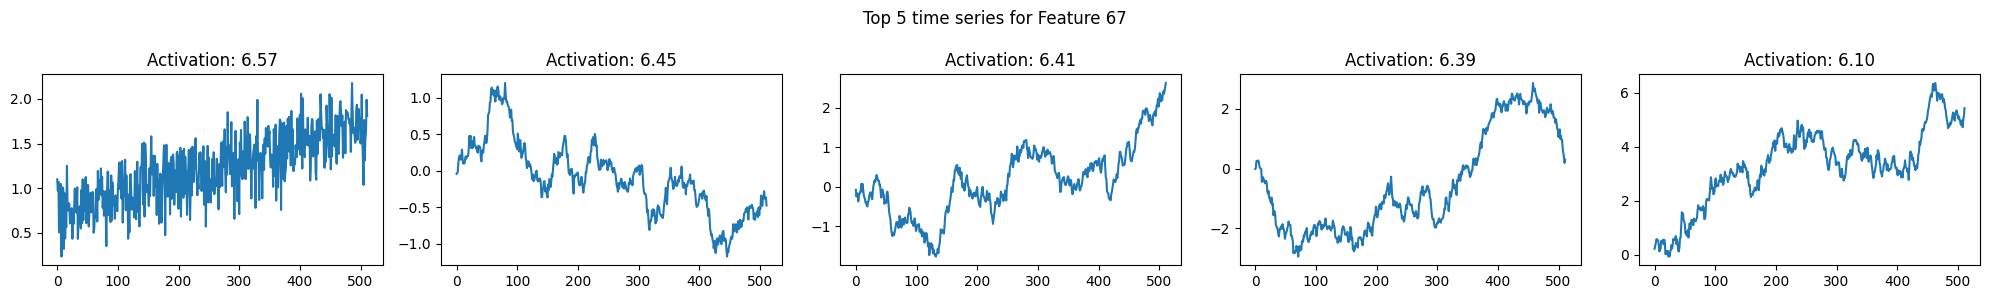

In [ ]:
@torch.no_grad()
def find_max_activating_examples(sae, extractor, data_gen, feature_idx, n_search=500):
    """
    Find time series that maximally activate a specific feature.
    """
    sae.eval()

    max_activations = []
    all_ts = []

    for _ in range(n_search // config.batch_size + 1):
        ts_batch = data_gen.generate_batch(config.batch_size)
        acts = extractor.extract(ts_batch)
        output = sae(acts)

        # Get max activation of target feature across sequence
        feature_acts = output["features"][..., feature_idx]  # (batch, seq)
        max_per_ts = feature_acts.max(dim=-1).values  # (batch,)

        max_activations.extend(max_per_ts.cpu().tolist())
        all_ts.extend([ts.cpu() for ts in ts_batch])

    # Find top activating examples
    sorted_indices = np.argsort(max_activations)[::-1][:5]

    # Plot
    fig, axes = plt.subplots(1, 5, figsize=(20, 3))
    for i, idx in enumerate(sorted_indices):
        axes[i].plot(all_ts[idx].numpy())
        axes[i].set_title(f"Activation: {max_activations[idx]:.2f}")

    plt.suptitle(f"Top 5 time series for Feature {feature_idx}")
    plt.tight_layout()
    plt.show()

# Analyze top features
print("Analyzing top activating features...")
for i, feat_idx in enumerate(top_features[:3].tolist()):
    print(f"\nFeature {feat_idx} (rank {i+1}):")
    find_max_activating_examples(sae, extractor, data_gen, feat_idx)

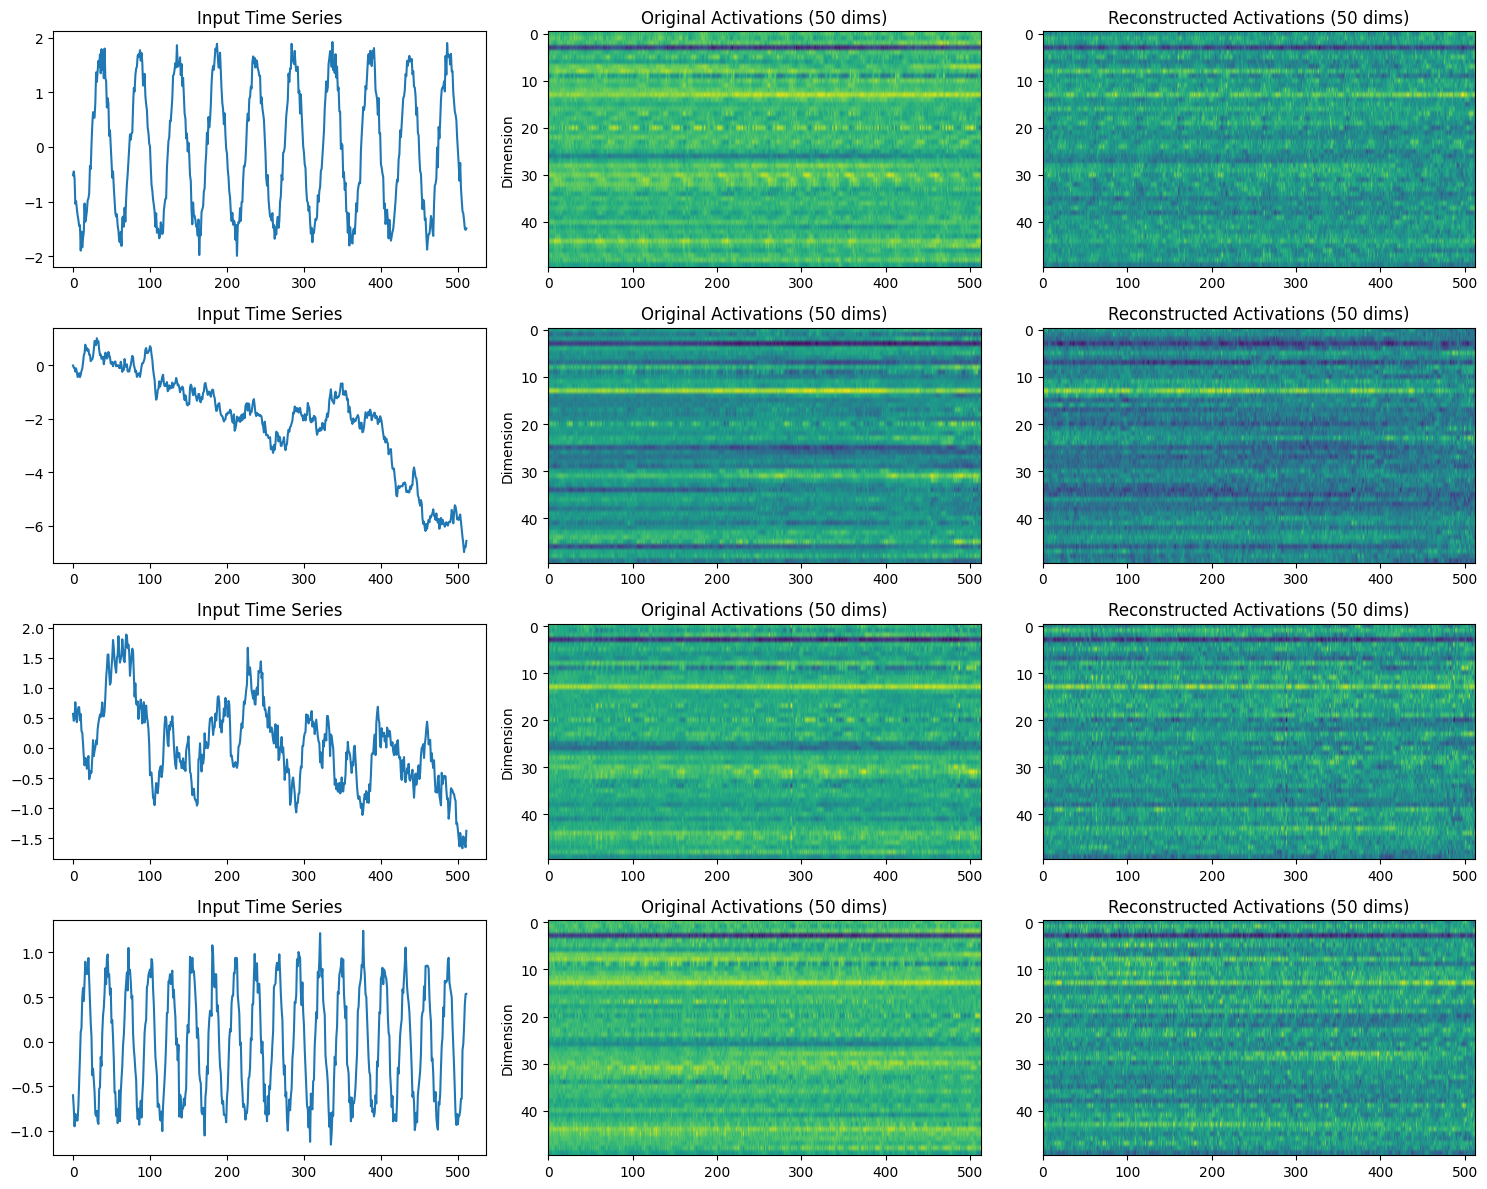

Overall reconstruction metrics:
  MSE: 12.8717
  Cosine similarity: 0.5760
  L0 sparsity: 32.0


In [ ]:
@torch.no_grad()
def visualize_reconstructions(sae, extractor, data_gen, n_examples=4):
    """Visualize original vs reconstructed activations."""
    sae.eval()

    # Generate examples
    ts_batch = data_gen.generate_batch(n_examples)
    acts = extractor.extract(ts_batch)  # (n, seq, d_model)
    output = sae(acts)

    # Compare
    fig, axes = plt.subplots(n_examples, 3, figsize=(15, 3*n_examples))

    for i in range(n_examples):
        # Original time series
        axes[i, 0].plot(ts_batch[i].cpu().numpy())
        axes[i, 0].set_title("Input Time Series")

        # Activation heatmap (first 50 dims)
        axes[i, 1].imshow(acts[i, :, :50].cpu().numpy().T, aspect="auto", cmap="viridis")
        axes[i, 1].set_title("Original Activations (50 dims)")
        axes[i, 1].set_ylabel("Dimension")

        # Reconstruction heatmap
        axes[i, 2].imshow(output["reconstruction"][i, :, :50].cpu().numpy().T, aspect="auto", cmap="viridis")
        axes[i, 2].set_title("Reconstructed Activations (50 dims)")

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"Overall reconstruction metrics:")
    print(f"  MSE: {output['mse_loss']:.4f}")
    print(f"  Cosine similarity: {output['cos_sim']:.4f}")
    print(f"  L0 sparsity: {output['l0']:.1f}")

visualize_reconstructions(sae, extractor, data_gen)

In [ ]:
# Final summary
print("="*60)
print("TRAINING SUMMARY")
print("="*60)
print(f"Model: {config.chronos_model}")
print(f"Layer: {config.layer_idx}")
print(f"SAE dimensions: {config.d_model} -> {config.d_sae}")
print(f"Sparsity (k): {config.k}")
print(f"Steps completed: {trainer.step}")

if trainer.history["mse"]:
    print(f"\nFinal metrics:")
    print(f"  MSE: {trainer.history['mse'][-1]:.4f}")
    print(f"  L0: {trainer.history['l0'][-1]:.1f}")
    print(f"  Cosine similarity: {trainer.history['cos_sim'][-1]:.4f}")

print(f"\nCheckpoints saved to: {checkpoint_dir}")

TRAINING SUMMARY
Model: amazon/chronos-t5-small
Layer: 4
SAE dimensions: 512 -> 4096
Sparsity (k): 32
Steps completed: 10

Checkpoints saved to: ./sae_checkpoints
